In [1]:
from __future__ import division

import pickle
import math

import numpy as np
from scipy.special import digamma, gammaln


def get_preprocessed_data(m=100):
    with open('normalized_tokenized_data.pkl', 'rb') as f:
        documents = pickle.load(f)[:m]
    vocabulary = set()
    for datum in documents:
        vocabulary.update(datum)
    vocabulary = list(vocabulary)
    return documents, vocabulary


def doc_to_match_given_vocabulary(doc, word):
    return (np.array(doc) == word).astype(int)


def initialization(documents, K, M, V, alpha_init=1.0, beta_init=0, dtype=np.float32):
    alpha = np.repeat(alpha_init, K) * 50 / K
    beta = np.full([K, V], beta_init, dtype=dtype)
    for k in range(0, K):
        unnormalized_probability = np.random.uniform(0, 1, V)
        beta[k, :] = unnormalized_probability / np.sum(unnormalized_probability)
    gamma = np.full([M, K], 0, dtype=dtype)
    phi = []
    for m, doc in enumerate(documents):
        gamma[m, :] = alpha + len(doc) / K
        phi += [np.full([len(doc), K], 1 / K)]
    return alpha, beta, phi, gamma


def E_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    print("E-Step")
    for m, doc in enumerate(documents):
        converge = False
        converge_iteration = 0
        while not converge:
            phi_old = np.array(phi[m], copy=True)
            gamma_old = np.array(gamma[m], copy=True)
            for n in range(len(doc)):
                for i in range(K):
                    word_idx = vocabulary.index(doc[n])
                    phi[m][n][i] = beta[i, word_idx] * math.exp(digamma(gamma[m, i]) - digamma(np.sum(gamma[m, :])))
                if np.sum(phi[m][n]) == 0:
                    print("beta: {0} | digamma: {1} | digamma_sum: {2} | word: {3}".format(beta[i, word_idx],
                                                                               digamma(gamma[m, i]),
                                                                               digamma(np.sum(gamma[m])),
                                                                                vocabulary[word_idx]))
                phi[m][n] = phi[m][n] / np.sum(phi[m][n])  # Normalization
            gamma[m] = alpha + np.sum(phi[m], axis=0)
            phi_error = np.linalg.norm(phi_old - phi[m])
            gamma_error = np.linalg.norm(gamma_old - gamma[m])
            if phi_error < 1e-3 and gamma_error < 1e-3:
                converge = True
                print("Document: {0} | Iteration: {1} | "
                      "Phi_err: {2} | Gamma_err: {3}".format(m, converge_iteration,
                                                             phi_error, gamma_error))
            converge_iteration += 1
    return phi, gamma


def M_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    print("M-Step")
    beta_old = np.array(beta, copy=True)
    beta = np.zeros([K, V], dtype=np.float32)
    for m, doc in enumerate(documents):
        for j in range(V):
            w_j = doc_to_match_given_vocabulary(doc, vocabulary[j])
            beta[:, j] += np.dot(w_j, phi[m])

    beta = beta / np.sum(beta, axis=1)[:, None]
    if np.any(beta == 0.0):
        print("Skip Updating Beta as there is an element in beta equals to zero.")
        return alpha, beta_old
        
    alpha = alpha
    return alpha, beta


def likelihood_per_document(alpha, beta, phi, gamma, doc, vocabulary, K, M, V):
    gamma_total = -np.log(gammaln(np.sum(gamma))) + np.sum(np.log(gammaln(gamma)))
    alpha_total = np.log(gammaln(np.sum(alpha))) - np.sum(np.log(gammaln(alpha)))
    phi_entropy = -np.sum(phi * np.log(phi))
    phi_digamma_gamma = np.dot(phi, digamma(gamma) - digamma(np.sum(gamma))).sum()
    alpha_digamma_gamma = np.dot(alpha - 1, digamma(gamma) - digamma(np.sum(gamma))).sum()
    gamma_digamma_gamma = np.dot(gamma - 1, digamma(gamma) - digamma(np.sum(gamma))).sum()
    word_matrix = np.zeros([len(doc), len(vocabulary)])
    phi_log_beta = np.dot(phi, np.log(beta))
    if not (np.Infinity in phi_log_beta or -np.Infinity in phi_log_beta):
        for idx, word in enumerate(doc):
            word_matrix[idx, vocabulary.index(word)] = 1
        phi_word_log_beta = np.sum(np.multiply(phi_log_beta, word_matrix))
    else:
        phi_word_log_beta = 0
    return gamma_total + alpha_total + phi_entropy + phi_digamma_gamma + \
           alpha_digamma_gamma + gamma_digamma_gamma + phi_word_log_beta


def get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    likelihood_total = 0
    for m, doc in enumerate(documents):
        likelihood_total += likelihood_per_document(alpha, beta, phi[m], gamma[m], doc, vocabulary, K, M, V)
    return likelihood_total


def variational_inference(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    likelihood = 0
    likelihood_previous = -1e3
    iteration = 0
    likelihood = get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
    print("Iteration: {0} | likelihood: {1} | likelihood_previous: {2}".format(-1, likelihood, 'NA'))
    while abs(likelihood - likelihood_previous) > 1e-4:
        likelihood_previous = likelihood
        phi, gamma = E_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        alpha, beta = M_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        likelihood = get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        print("Iteration: {0} | likelihood: {1} | likelihood_previous: {2}".format(iteration, likelihood, likelihood_previous))
        iteration += 1
    return alpha, beta, phi, gamma


def LDA(documents, vocabulary, K=4):
    M = len(documents)
    V = len(vocabulary)
    alpha, beta, phi, gamma = initialization(documents, K, M, V)
    alpha, beta, phi, gamma = \
        variational_inference(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
    return alpha, beta, phi, gamma




In [2]:

m = 50
K = 10
documents, vocabulary = get_preprocessed_data(m=m)
print("Number of Vocabulary: {0}".format(len(vocabulary)))
alpha, beta, phi, gamma = LDA(documents, vocabulary, K)

Number of Vocabulary: 4258
Iteration: -1 | likelihood: -135206.44184689794 | likelihood_previous: NA
E-Step
Document: 0 | Iteration: 52 | Phi_err: 5.643755758637474e-05 | Gamma_err: 0.0008887036819942296
Document: 1 | Iteration: 53 | Phi_err: 5.602091011546625e-05 | Gamma_err: 0.0008985130698420107
Document: 2 | Iteration: 52 | Phi_err: 6.432355681172001e-05 | Gamma_err: 0.000998654984869063
Document: 3 | Iteration: 43 | Phi_err: 6.514353844919556e-05 | Gamma_err: 0.0009097113506868482
Document: 4 | Iteration: 18 | Phi_err: 0.0001005481834667448 | Gamma_err: 0.0008526776218786836
Document: 5 | Iteration: 75 | Phi_err: 4.652784006757893e-05 | Gamma_err: 0.0009321550605818629
Document: 6 | Iteration: 44 | Phi_err: 6.655383458601363e-05 | Gamma_err: 0.0008584382594563067
Document: 7 | Iteration: 15 | Phi_err: 0.00011219936624578723 | Gamma_err: 0.000814983737654984
Document: 8 | Iteration: 4 | Phi_err: 9.924921916408579e-05 | Gamma_err: 0.0002293824654771015
Document: 9 | Iteration: 30 | 

Document: 33 | Iteration: 34 | Phi_err: 9.007461362933829e-05 | Gamma_err: 0.0009227670379914343
Document: 34 | Iteration: 57 | Phi_err: 5.980529482362151e-05 | Gamma_err: 0.0009383903234265745
Document: 35 | Iteration: 36 | Phi_err: 7.272979576893772e-05 | Gamma_err: 0.000819941982626915
Document: 36 | Iteration: 51 | Phi_err: 5.917924971254528e-05 | Gamma_err: 0.0009411954088136554
Document: 37 | Iteration: 42 | Phi_err: 6.300282060062078e-05 | Gamma_err: 0.0008360020001418889
Document: 38 | Iteration: 59 | Phi_err: 6.000038993928321e-05 | Gamma_err: 0.0009659722563810647
Document: 39 | Iteration: 30 | Phi_err: 9.297096457315064e-05 | Gamma_err: 0.000926331034861505
Document: 40 | Iteration: 59 | Phi_err: 4.954767627090798e-05 | Gamma_err: 0.0008736619492992759
Document: 41 | Iteration: 34 | Phi_err: 8.818859121161163e-05 | Gamma_err: 0.0009693601168692112
Document: 42 | Iteration: 44 | Phi_err: 5.0701729825022426e-05 | Gamma_err: 0.0008442915859632194
Document: 43 | Iteration: 34 | 

Document: 16 | Iteration: 20 | Phi_err: 0.00010100947185410232 | Gamma_err: 0.0009770281612873077
Document: 17 | Iteration: 34 | Phi_err: 5.85933196251374e-05 | Gamma_err: 0.000992808723822236
Document: 18 | Iteration: 25 | Phi_err: 5.197806633462377e-05 | Gamma_err: 0.0007445761584676802
Document: 19 | Iteration: 6 | Phi_err: 4.3186042287853133e-05 | Gamma_err: 0.0004095609183423221
Document: 20 | Iteration: 21 | Phi_err: 0.00010151800924232872 | Gamma_err: 0.0007450275006704032
Document: 21 | Iteration: 4 | Phi_err: 0.00034105356876632626 | Gamma_err: 0.0009657189948484302
Document: 22 | Iteration: 5 | Phi_err: 0.00012428717227091053 | Gamma_err: 0.0002760211646091193
Document: 23 | Iteration: 18 | Phi_err: 7.369714286335471e-05 | Gamma_err: 0.0006308454903773963
Document: 24 | Iteration: 20 | Phi_err: 5.6701092343118325e-05 | Gamma_err: 0.0006653486634604633
Document: 25 | Iteration: 11 | Phi_err: 0.00014943290740928512 | Gamma_err: 0.0009000572608783841
Document: 26 | Iteration: 19

Iteration: 4 | likelihood: -93627.79446444211 | likelihood_previous: -96788.82053053075
E-Step
Document: 0 | Iteration: 5 | Phi_err: 6.36222422200884e-05 | Gamma_err: 0.00045603583566844463
Document: 1 | Iteration: 15 | Phi_err: 7.688977675869927e-05 | Gamma_err: 0.0005964275915175676
Document: 2 | Iteration: 6 | Phi_err: 5.642772455757933e-05 | Gamma_err: 0.0003915791166946292
Document: 3 | Iteration: 12 | Phi_err: 8.066649571665475e-05 | Gamma_err: 0.0005325263482518494
Document: 4 | Iteration: 11 | Phi_err: 0.00013081757812223916 | Gamma_err: 0.0006943038897588849
Document: 5 | Iteration: 6 | Phi_err: 4.851321604413409e-05 | Gamma_err: 0.00046492283581756055
Document: 6 | Iteration: 8 | Phi_err: 0.00011021580295520299 | Gamma_err: 0.0005972424987703562
Document: 7 | Iteration: 7 | Phi_err: 0.0001453150222304023 | Gamma_err: 0.0006609215633943677
Document: 8 | Iteration: 4 | Phi_err: 0.00012399685605874217 | Gamma_err: 0.0002373557217651978
Document: 9 | Iteration: 6 | Phi_err: 4.385

Document: 33 | Iteration: 5 | Phi_err: 5.2710807207422644e-05 | Gamma_err: 0.00026583147700876
Document: 34 | Iteration: 5 | Phi_err: 3.8105723994536884e-05 | Gamma_err: 0.00032697818824090064
Document: 35 | Iteration: 4 | Phi_err: 8.041467426660355e-05 | Gamma_err: 0.0002980670833494514
Document: 36 | Iteration: 5 | Phi_err: 8.716392382987632e-05 | Gamma_err: 0.0008998630801215768
Document: 37 | Iteration: 5 | Phi_err: 0.0001008267255242608 | Gamma_err: 0.0006073102704249322
Document: 38 | Iteration: 4 | Phi_err: 0.0001502204998053322 | Gamma_err: 0.0009355769725516438
Document: 39 | Iteration: 5 | Phi_err: 6.995217212292119e-05 | Gamma_err: 0.00036585438647307456
Document: 40 | Iteration: 10 | Phi_err: 0.00010506336105940043 | Gamma_err: 0.0009229432907886803
Document: 41 | Iteration: 11 | Phi_err: 0.000114278858952402 | Gamma_err: 0.0006474556867033243
Document: 42 | Iteration: 5 | Phi_err: 5.4317133311845865e-05 | Gamma_err: 0.0006526082288473845
Document: 43 | Iteration: 4 | Phi_e

Document: 17 | Iteration: 4 | Phi_err: 6.51820442323615e-05 | Gamma_err: 0.00045829606824554503
Document: 18 | Iteration: 11 | Phi_err: 8.621224421865078e-05 | Gamma_err: 0.0007369322120212018
Document: 19 | Iteration: 3 | Phi_err: 8.865632470573077e-05 | Gamma_err: 0.0007654573419131339
Document: 20 | Iteration: 6 | Phi_err: 9.613418623959513e-05 | Gamma_err: 0.0003969599783886224
Document: 21 | Iteration: 4 | Phi_err: 0.00016012863631571902 | Gamma_err: 0.00031804179889149964
Document: 22 | Iteration: 2 | Phi_err: 0.0005120301956965218 | Gamma_err: 0.0008272355189546943
Document: 23 | Iteration: 5 | Phi_err: 0.00019014252824936824 | Gamma_err: 0.0008333858568221331
Document: 24 | Iteration: 3 | Phi_err: 0.00011530355807470722 | Gamma_err: 0.0007288461783900857
Document: 25 | Iteration: 4 | Phi_err: 0.0001186901845990227 | Gamma_err: 0.0007059585186652839
Document: 26 | Iteration: 3 | Phi_err: 3.8274425270285234e-05 | Gamma_err: 0.0003664619871415198
Document: 27 | Iteration: 4 | Phi_

Document: 0 | Iteration: 3 | Phi_err: 3.627556446587732e-05 | Gamma_err: 0.0002848542353603989
Document: 1 | Iteration: 8 | Phi_err: 6.34776963077585e-05 | Gamma_err: 0.00048658446758054197
Document: 2 | Iteration: 3 | Phi_err: 6.980597068469968e-05 | Gamma_err: 0.0005409246077761054
Document: 3 | Iteration: 4 | Phi_err: 7.239700898033495e-05 | Gamma_err: 0.0005685017094947398
Document: 4 | Iteration: 4 | Phi_err: 0.00018201281655280275 | Gamma_err: 0.0009171462734229863
Document: 5 | Iteration: 2 | Phi_err: 8.313040434155824e-05 | Gamma_err: 0.0008372182492166758
Document: 6 | Iteration: 3 | Phi_err: 8.456783000689208e-05 | Gamma_err: 0.0006327183218672872
Document: 7 | Iteration: 2 | Phi_err: 0.00021644433683961256 | Gamma_err: 0.0005652401014231145
Document: 8 | Iteration: 2 | Phi_err: 0.00044821301830750334 | Gamma_err: 0.0006231029983609915
Document: 9 | Iteration: 2 | Phi_err: 0.00014987000040990507 | Gamma_err: 0.0005747302202507854
Document: 10 | Iteration: 5 | Phi_err: 0.00016

Document: 35 | Iteration: 3 | Phi_err: 6.865408158585977e-05 | Gamma_err: 0.000376781914383173
Document: 36 | Iteration: 2 | Phi_err: 4.576908313093995e-05 | Gamma_err: 0.00029944386915303767
Document: 37 | Iteration: 3 | Phi_err: 0.00013962632033559118 | Gamma_err: 0.000995050766505301
Document: 38 | Iteration: 2 | Phi_err: 7.684930703927155e-05 | Gamma_err: 0.0006256114575080574
Document: 39 | Iteration: 4 | Phi_err: 7.272855398232586e-05 | Gamma_err: 0.0003786771558225155
Document: 40 | Iteration: 5 | Phi_err: 8.746152907670075e-05 | Gamma_err: 0.0007945842808112502
Document: 41 | Iteration: 8 | Phi_err: 0.00010399684178369757 | Gamma_err: 0.0005778929917141795
Document: 42 | Iteration: 2 | Phi_err: 5.856012909280788e-05 | Gamma_err: 0.0005969818448647857
Document: 43 | Iteration: 3 | Phi_err: 6.767712492181939e-05 | Gamma_err: 0.00041686586337164044
Document: 44 | Iteration: 4 | Phi_err: 5.821857080912858e-05 | Gamma_err: 0.00044729383080266416
Document: 45 | Iteration: 2 | Phi_err

Document: 19 | Iteration: 1 | Phi_err: 0.00010324976699022211 | Gamma_err: 0.0006687319255433977
Document: 20 | Iteration: 4 | Phi_err: 0.00010987388259847716 | Gamma_err: 0.0005337275797501206
Document: 21 | Iteration: 4 | Phi_err: 0.00013018501665964353 | Gamma_err: 0.0002450344618409872
Document: 22 | Iteration: 2 | Phi_err: 0.00042818272625815067 | Gamma_err: 0.0006686846609227359
Document: 23 | Iteration: 3 | Phi_err: 5.888823535187758e-05 | Gamma_err: 0.00028541364008560777
Document: 24 | Iteration: 3 | Phi_err: 5.7338717067681334e-05 | Gamma_err: 0.0003801989369094372
Document: 25 | Iteration: 1 | Phi_err: 6.897611477269699e-05 | Gamma_err: 0.0003558371390681714
Document: 26 | Iteration: 1 | Phi_err: 5.6680143212681e-05 | Gamma_err: 0.000526579562574625
Document: 27 | Iteration: 3 | Phi_err: 9.264865155568027e-05 | Gamma_err: 0.0005993492086417973
Document: 28 | Iteration: 1 | Phi_err: 7.148165306354876e-05 | Gamma_err: 0.00045601665624417365
Document: 29 | Iteration: 2 | Phi_er

Document: 2 | Iteration: 1 | Phi_err: 0.00014507114008647438 | Gamma_err: 0.0007750667864456773
Document: 3 | Iteration: 2 | Phi_err: 0.0001873294059904894 | Gamma_err: 0.000867428258061409
Document: 4 | Iteration: 1 | Phi_err: 0.0001523842045682046 | Gamma_err: 0.0006206143298186362
Document: 5 | Iteration: 1 | Phi_err: 0.00010677238997200366 | Gamma_err: 0.0009608007385395467
Document: 6 | Iteration: 2 | Phi_err: 4.0747602644672326e-05 | Gamma_err: 0.0002780066861305386
Document: 7 | Iteration: 2 | Phi_err: 0.00011723859100399382 | Gamma_err: 0.0005035111680626869
Document: 8 | Iteration: 3 | Phi_err: 0.0001049413014769689 | Gamma_err: 0.0001584262354299426
Document: 9 | Iteration: 1 | Phi_err: 0.00018345787131090235 | Gamma_err: 0.000656544347293675
Document: 10 | Iteration: 4 | Phi_err: 0.0001264468899032766 | Gamma_err: 0.0006053257384337485
Document: 11 | Iteration: 2 | Phi_err: 7.964077825946562e-05 | Gamma_err: 0.0003473859396763146
Document: 12 | Iteration: 2 | Phi_err: 8.1889

Document: 37 | Iteration: 2 | Phi_err: 0.00014166638092419115 | Gamma_err: 0.0009665251709520817
Document: 38 | Iteration: 1 | Phi_err: 9.070048407369126e-05 | Gamma_err: 0.0007581827812828124
Document: 39 | Iteration: 2 | Phi_err: 0.00016584490082790658 | Gamma_err: 0.0008454868802800775
Document: 40 | Iteration: 2 | Phi_err: 0.00015319111854604367 | Gamma_err: 0.0009448782075196505
Document: 41 | Iteration: 7 | Phi_err: 0.0001322749325322082 | Gamma_err: 0.0007371578831225634
Document: 42 | Iteration: 1 | Phi_err: 0.00012136164980331926 | Gamma_err: 0.000764767115470022
Document: 43 | Iteration: 2 | Phi_err: 7.242305520117505e-05 | Gamma_err: 0.0003470064257271588
Document: 44 | Iteration: 3 | Phi_err: 9.262528794670108e-05 | Gamma_err: 0.0006981348851695657
Document: 45 | Iteration: 1 | Phi_err: 0.00012513146695670315 | Gamma_err: 0.0005337690818123519
Document: 46 | Iteration: 2 | Phi_err: 8.328660653623041e-05 | Gamma_err: 0.0003193911979906261
Document: 47 | Iteration: 1 | Phi_er

Document: 20 | Iteration: 3 | Phi_err: 0.0001294145950753987 | Gamma_err: 0.0006146107334643602
Document: 21 | Iteration: 3 | Phi_err: 0.00010275027064649169 | Gamma_err: 0.00017070370086003095
Document: 22 | Iteration: 2 | Phi_err: 5.254821924032937e-05 | Gamma_err: 7.349946099566296e-05
Document: 23 | Iteration: 2 | Phi_err: 5.5169568573024484e-05 | Gamma_err: 0.0002948107139673084
Document: 24 | Iteration: 2 | Phi_err: 0.00011250200361019676 | Gamma_err: 0.0007229169132187963
Document: 25 | Iteration: 2 | Phi_err: 4.7993020278493734e-05 | Gamma_err: 0.0003066081553697586
Document: 26 | Iteration: 2 | Phi_err: 2.3280287935209798e-05 | Gamma_err: 0.00022868307132739574
Document: 27 | Iteration: 3 | Phi_err: 0.00012418189473843288 | Gamma_err: 0.000532170757651329
Document: 28 | Iteration: 1 | Phi_err: 6.660070553746959e-05 | Gamma_err: 0.0003762580454349518
Document: 29 | Iteration: 1 | Phi_err: 0.00016769274182275816 | Gamma_err: 0.0007829372771084309
Document: 30 | Iteration: 2 | Ph

Document: 4 | Iteration: 2 | Phi_err: 0.00012318721437538132 | Gamma_err: 0.0007062893710099161
Document: 5 | Iteration: 1 | Phi_err: 9.17856037752009e-05 | Gamma_err: 0.0008205576450563967
Document: 6 | Iteration: 1 | Phi_err: 5.4594611565567495e-05 | Gamma_err: 0.00024995001149363816
Document: 7 | Iteration: 1 | Phi_err: 0.0002451423354997749 | Gamma_err: 0.0009223099332302809
Document: 8 | Iteration: 2 | Phi_err: 0.0002585895597896927 | Gamma_err: 0.00034064732608385384
Document: 9 | Iteration: 1 | Phi_err: 0.00010661655265581648 | Gamma_err: 0.0005288988468237221
Document: 10 | Iteration: 3 | Phi_err: 0.0001409795408703143 | Gamma_err: 0.0007088228594511747
Document: 11 | Iteration: 1 | Phi_err: 0.00016606866692946013 | Gamma_err: 0.000566311355214566
Document: 12 | Iteration: 1 | Phi_err: 0.00015603513427983755 | Gamma_err: 0.0006934233824722469
Document: 13 | Iteration: 4 | Phi_err: 0.0002392286717575604 | Gamma_err: 0.0006418410339392722
Document: 14 | Iteration: 3 | Phi_err: 0.

Document: 38 | Iteration: 0 | Phi_err: 5.432169016104967e-06 | Gamma_err: 3.535675932653248e-05
Document: 39 | Iteration: 0 | Phi_err: 3.304036720296509e-05 | Gamma_err: 0.00016664349823258817
Document: 40 | Iteration: 0 | Phi_err: 3.951285074972549e-05 | Gamma_err: 0.00023427266569342464
Document: 41 | Iteration: 0 | Phi_err: 5.537505972498733e-05 | Gamma_err: 0.00030397946829907596
Document: 42 | Iteration: 0 | Phi_err: 3.186672758549362e-05 | Gamma_err: 0.00020003474492114037
Document: 43 | Iteration: 0 | Phi_err: 4.355218410801541e-05 | Gamma_err: 0.00014660009765066206
Document: 44 | Iteration: 0 | Phi_err: 1.8232122489068263e-05 | Gamma_err: 0.00012075847917003557
Document: 45 | Iteration: 0 | Phi_err: 3.8409568096035936e-05 | Gamma_err: 0.0001495445321779698
Document: 46 | Iteration: 0 | Phi_err: 1.0249660918897125e-05 | Gamma_err: 5.4044816351961344e-05
Document: 47 | Iteration: 0 | Phi_err: 6.789954358772222e-06 | Gamma_err: 6.465321348514408e-05
Document: 48 | Iteration: 0 | 

Document: 24 | Iteration: 0 | Phi_err: 3.950455806798886e-06 | Gamma_err: 3.8779497117502615e-05
Document: 25 | Iteration: 0 | Phi_err: 4.441026805754199e-06 | Gamma_err: 2.349118767597247e-05
Document: 26 | Iteration: 0 | Phi_err: 1.1653846117195175e-06 | Gamma_err: 3.0803090339759365e-05
Document: 27 | Iteration: 0 | Phi_err: 4.442240387418838e-06 | Gamma_err: 2.2421489120461047e-05
Document: 28 | Iteration: 0 | Phi_err: 3.5250097937871544e-07 | Gamma_err: 1.6518123402420315e-06
Document: 29 | Iteration: 0 | Phi_err: 3.478169033038247e-06 | Gamma_err: 1.6345155017916113e-05
Document: 30 | Iteration: 0 | Phi_err: 1.7237433128139e-06 | Gamma_err: 3.209719943697564e-05
Document: 31 | Iteration: 0 | Phi_err: 8.200215099082073e-06 | Gamma_err: 5.347383921616711e-05
Document: 32 | Iteration: 0 | Phi_err: 8.43075285969141e-06 | Gamma_err: 2.9942184482933953e-05
Document: 33 | Iteration: 0 | Phi_err: 1.4637265075392506e-06 | Gamma_err: 4.76837158203125e-06
Document: 34 | Iteration: 0 | Phi_e

Document: 10 | Iteration: 0 | Phi_err: 1.2118766823577453e-06 | Gamma_err: 5.761645297752693e-06
Document: 11 | Iteration: 0 | Phi_err: 1.4872662505164206e-07 | Gamma_err: 6.743495646333031e-07
Document: 12 | Iteration: 0 | Phi_err: 3.935078791683925e-07 | Gamma_err: 1.5078915112098912e-06
Document: 13 | Iteration: 0 | Phi_err: 3.6785905876191877e-07 | Gamma_err: 1.1680077705022995e-06
Document: 14 | Iteration: 0 | Phi_err: 2.361939926896674e-06 | Gamma_err: 1.4321000890049618e-05
Document: 15 | Iteration: 0 | Phi_err: 9.135951016091725e-07 | Gamma_err: 1.5757284927531146e-05
Document: 16 | Iteration: 0 | Phi_err: 1.7436207294616403e-07 | Gamma_err: 4.76837158203125e-07
Document: 17 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 18 | Iteration: 0 | Phi_err: 3.17496795857355e-06 | Gamma_err: 2.490076258254703e-05
Document: 19 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 20 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 21 | Iteration: 0 | Phi_err: 0.0 | G

Document: 12 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 13 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 14 | Iteration: 0 | Phi_err: 4.723867291920784e-07 | Gamma_err: 2.90048728857073e-06
Document: 15 | Iteration: 0 | Phi_err: 2.2987070830516141e-07 | Gamma_err: 1.0662403155947686e-06
Document: 16 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 17 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 18 | Iteration: 0 | Phi_err: 4.465656768454682e-07 | Gamma_err: 2.1324806311895372e-06
Document: 19 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 20 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 21 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 22 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 23 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 24 | Iteration: 0 | Phi_err: 2.1001110150676346e-07 | Gamma_err: 1.5078915112098912e-06
Document: 25 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 26

In [5]:
for k in range(K):
    word_idx = np.where(np.argmax(beta, axis=0)==k)
    top_n_word = np.argsort(beta[k][word_idx])[-20:][::-1]
    print(np.array(vocabulary)[top_n_word])

['crowd' 'presence' 'pride' 'reparations' 'independent' 'humanitarian'
 'improved' 'controlling' 'm551' 'pickin' 'york' 'materialize' 'external'
 'tackled' 'determined' 'henchmen' 'eastern' 'cent' 'discovery' 'man']
['makes' 'americas' 'elusive' 'materialize' 'treaty' 'washington' 'shaky'
 'ether' 'bradley' 'minute' 'try' 'mining' 'alternate' 'circled' 'dim'
 'supposed' 'everybody' 'summer' 'cent' 'entirely']
['reacted' 'aggression' 'representatives' 'call' 'birthdays' 'calling'
 'loaded' 'czechoslovaks' 'suggest' 'lynn' 'attracted' 'capital'
 'discussed' 'weapons' 'discovery' 'alone' 'countries' 'theater' 'mark'
 'slayings']
['economists' 'layoffs' 'hitler' 'lundberg' 'stressed' 'first' 'et' 'pool'
 'visited' 'kui' 'raw' 'henchmen' 'aggression' 'phyllis' 'politician'
 'crown' 'banking' 'parking' 'try' 'camp']
['pleased' 'presence' 'weapons' 'economists' 'voted' 'average'
 'propaganda' 'scathing' 'decade' 'allegedly' 'yards' 'eliminate'
 'discussed' 'native' 'lifts' 'walking' 'policy' 

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
group = KMeans(n_clusters=3, random_state=0).fit_predict(gamma)
dot = PCA(n_components=2).fit_transform(gamma)

In [11]:
group

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2])

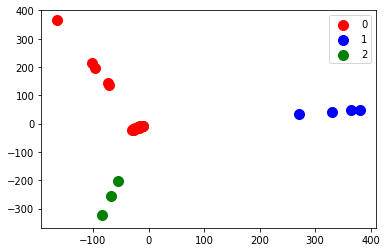

In [8]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(dot[ix, 0], dot[ix, 1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [9]:
documents, vocabulary = get_preprocessed_data(m=m)


In [16]:
ix_0 = np.where(group == 0)
ix_1 = np.where(group == 1)
ix_2 = np.where(group == 2)

In [29]:
ix_1

(array([19, 24, 29, 40], dtype=int64),)

In [28]:
ix_2

(array([28, 36, 49], dtype=int64),)

In [27]:
documents[19]

['nasa',
 'scientists',
 'rejoiced',
 'pretty',
 'damn',
 'good',
 'test',
 'photos',
 'magellan',
 'probe',
 'today',
 'also',
 'grappled',
 'communications',
 'difficulties',
 'spacecraft',
 'circled',
 'venus',
 'fifteen',
 'hours',
 'spacecraft',
 'lost',
 'contact',
 'earth',
 'thursday',
 'evening',
 'signal',
 'established',
 'signal',
 'failed',
 'midday',
 'expected',
 'continue',
 'problem',
 'scientists',
 'could',
 'send',
 'magellan',
 'new',
 'instructions',
 'properly',
 'aim',
 'earth',
 'officials',
 'said',
 'meanwhile',
 'project',
 'manager',
 'tony',
 'spear',
 'said',
 'test',
 'pictures',
 'collected',
 'spacecraft',
 'radar',
 'mapper',
 'problems',
 'developed',
 'produced',
 'raw',
 'images',
 'looked',
 'pretty',
 'damn',
 'good',
 'said',
 'nasa',
 'release',
 'first',
 'pictures',
 'monday',
 'instead',
 'waiting',
 'september',
 'thursday',
 'test',
 'returned',
 'far',
 'pictures',
 'expected',
 'including',
 'several',
 'called',
 'noodles',
 'areas',
 '